# Fontainebleau clustering

In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pystan
import arviz as az
from sklearn.cluster import KMeans

sns.set(style='whitegrid')

In [2]:
df = (pd.read_excel('~/Dropbox/ROZ/data/Fontainebleau/7-Bourbie&Zinszner-1985_PT.xls', 
                   sheet_name=1,
                   skiprows=[0,1,3],
                   usecols=['porosity', 'permeability']
                  )
     .dropna()
     )
df

,porosity,permeability
0,3.1,0.075858
1,2.6,0.097724
2,3.1,0.097724
3,3.5,0.097724
4,3.9,0.097724
...,...,...
156,23.2,3548.133892
157,23.7,3548.133892
158,23.8,3162.277660
159,26.7,6456.542290


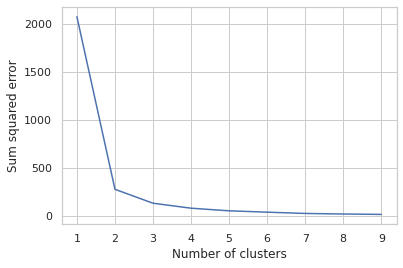

In [10]:
df_log = df.apply(np.log)
def train_and_inertia(df, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters).fit(df)
    return kmeans.inertia_
sse = pd.Series({k:train_and_inertia(df_log, k) for k in range(1, 10)})
sse.plot()
plt.gca().set(xlabel='Number of clusters', ylabel='Sum squared error')
plt.show()



In [15]:
df['cluster'] = KMeans(n_clusters=2).fit_predict(df_log) + 1 # Stan is one-indexed

[None]

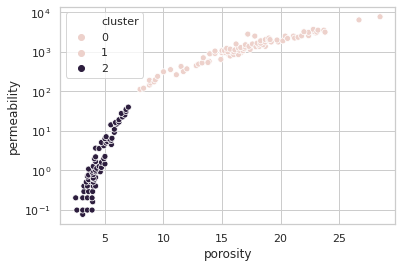

In [26]:
g = sns.scatterplot('porosity', 'permeability', hue='cluster', data=df)
g.set(yscale='log')

In [27]:
df.groupby('cluster')['porosity'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
1,89.0,16.823034,4.299611,8.0,14.4,16.8,19.10,28.5
2,72.0,4.539583,1.072477,2.5,3.9,4.2,5.25,7.0


In [57]:
model_code = """
data {
    int<lower=1> N;
    vector[N] phi;
    vector[N] perm;
    int<lower=1,upper=2> cluster[N];
}
transformed data {
    vector [N] logperm = log(perm);
}
parameters {
    real <lower=0> C_k[2];
    real <lower=0> t_exponent[2];
    real <lower=0, upper=2.5> phi_critical[2];
    real <lower=0> sigma_e[2];
}
transformed parameters {
    real mu[N];
    for (i in 1:N)
        mu[i] = log(C_k[cluster[i]]) + t_exponent[cluster[i]] * log(phi[i] - phi_critical[cluster[i]]);
}
model {
    /*C_k ~ lognormal(.2,1);*/
    t_exponent ~ normal(3, 1);
    phi_critical ~ normal(1.5, .5);
    for (i in 1:N)
        logperm[i] ~ normal(mu[i], sigma_e[cluster[i]]);
}
generated quantities {
    vector[N] log_lik;
    vector[N] y_hat;
    for (i in 1:N){
        log_lik[i] = normal_lpdf(logperm[i] | mu[i], sigma_e[cluster[i]]);
        y_hat[i] = exp(normal_rng(mu[i], sigma_e[cluster[i]]));
    }
}
"""
model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fdf3eb199763da58f0bf124489b701d6 NOW.


In [58]:
data = {'N': len(df.porosity), 'phi':df.porosity, 'perm': df.permeability, 'cluster': df.cluster}
fit = model.sampling(
    data=data, iter=5000, chains=4, warmup=1000, thin=1, seed=42, #adapt_delta = 1.0,
)
#fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_fdf3eb199763da58f0bf124489b701d6.
4 chains, each with iter=5000; warmup=1000; thin=1; 
post-warmup draws per chain=4000, total post-warmup draws=16000.

                  mean se_mean     sd   2.5%    25%    50%    75%   97.5%  n_eff   Rhat
C_k[1]            0.64  3.1e-3   0.25   0.27   0.46    0.6   0.79    1.23   6556    1.0
C_k[2]            0.01  1.5e-4   0.01 1.3e-3 5.1e-3 9.6e-3   0.02    0.05   6516    1.0
t_exponent[1]     2.81  1.4e-3   0.12   2.59   2.73    2.8   2.88    3.04   7280    1.0
t_exponent[2]     4.44  5.9e-3   0.47   3.56   4.12   4.43   4.75     5.4   6386    1.0
phi_critical[1]   1.52  5.0e-3   0.43   0.65   1.23   1.53   1.82    2.32   7524    1.0
phi_critical[2]    1.2  3.4e-3   0.27   0.63   1.02   1.21   1.39    1.68   6360    1.0
sigma_e[1]        0.18  1.4e-4   0.01   0.16   0.17   0.18   0.19    0.21  10862    1.0
sigma_e[2]        0.71  6.1e-4   0.06    0.6   0.66    0.7   0.75 

In [76]:
var_names = ['C_k','phi_critical','t_exponent']
az_fit = az.from_pystan(
    fit,
    posterior_predictive='y_hat',
    observed_data=["perm"], 
    log_likelihood = "log_lik",
    coords={"Cluster": ["High porosity","Low porosity"]}, 
    dims = {"phi_critical": ["Cluster"], "C_k":["Cluster"], "t_exponent":["Cluster"]}
)
az.summary(az_fit, var_names)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
C_k[0],0.644,0.248,0.231,1.104,0.003,0.002,6614.0,6065.0,7029.0,7937.0,1.0
C_k[1],0.013,0.012,0.000,0.034,0.000,0.000,6545.0,6545.0,6199.0,6871.0,1.0
phi_critical[0],1.518,0.431,0.745,2.353,0.005,0.004,7541.0,7164.0,7371.0,7022.0,1.0
phi_critical[1],1.198,0.270,0.703,1.708,0.003,0.002,6385.0,6385.0,6472.0,7020.0,1.0
t_exponent[0],2.807,0.116,2.597,3.031,0.001,0.001,7287.0,7287.0,7263.0,8648.0,1.0
t_exponent[1],4.442,0.469,3.566,5.318,0.006,0.004,6413.0,6355.0,6458.0,7714.0,1.0


[Text(0.5, 0, 'Variable value'), Text(0.5, 1.0, '')]

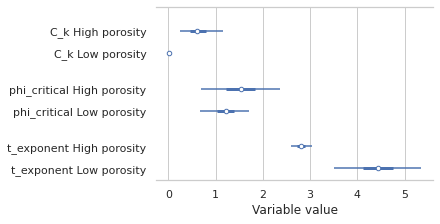

In [77]:
az.plot_forest(az_fit, var_names=var_names, figsize=(6,3), kind='forestplot', combined=True,
              credible_interval=0.95)
plt.gca().set(xlabel="Variable value", title='')
#plt.savefig('bayes_figures/Fontainebleau_forest.png', dpi=300, bbox_inches='tight')

In [75]:
az.loo(az_fit), az.waic(az_fit)

/home/frank/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/stats/stats.py:1194: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


(Computed from 16000 by 161 log-likelihood matrix
 
        Estimate       SE
 IC_loo   111.93    30.16
 p_loo      8.01        -,
 Computed from 16000 by 161 log-likelihood matrix
 
         Estimate       SE
 IC_waic   111.50    30.01
 p_waic      7.79        -
 
 There has been a warning during the calculation. Please check the results.)

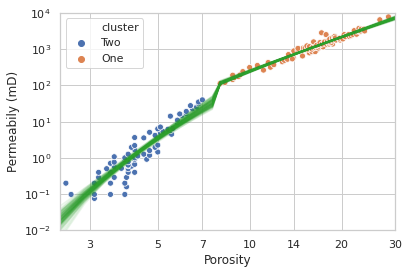

In [51]:
def log_posterior_examples(phi_predict, fit, num_examples=100):
    t = fit['t_exponent']
    phi_c = fit['phi_critical']
    perm0 = fit['C_k']
    phi_switch = 8
    samples = np.random.choice(len(t), num_examples)
    for e in samples:
        perm = np.zeros_like(phi_predict)
        perm[phi_predict > phi_switch] = perm0[e,0] * (phi_predict[phi_predict > phi_switch] - phi_c[e,0]) ** t[e,0]
        perm[phi_predict <= phi_switch] = perm0[e,1] * (phi_predict[phi_predict <= phi_switch] - phi_c[e,1]) ** t[e,1]
        yield perm

phi_fit = np.linspace(2.4, 30, 60)
for y in log_posterior_examples(phi_fit, fit, 100):
    plt.plot(phi_fit, y, color='tab:green', alpha=.1)
ax = plt.gca()
sc = sns.scatterplot('porosity', 'permeability', ax=ax, hue='cluster', 
                     data=df.assign(cluster=df.cluster.replace({1:'One',2:'Two'})))
#sc = df.plot.scatter('porosity', 'permeability', ax=ax, c='cluster', cmap='Wistia')
#porosity_pred = np.linspace(2.5, 35)
#k_pred = 0.51 * (porosity_pred - 2.366) ** 2.91
#plt.plot(porosity_pred, k_pred, label='Curve fit', color='crimson')
ax.set(
    xlabel='Porosity',
    xscale='log',
    xlim=(2.4, 30),
    ylabel='Permeabily (mD)',
    yscale='log', 
    ylim=(1e-2, 1e4)
)
#plt.legend()
plt.xticks([3,5,7,10,14,20,30],[3,5,7,10,14,20,30]);
#sns.despine()
plt.savefig('bayes_figures/Fontainebleau_fit.png', dpi=300, bbox_inches='tight')

In [54]:
az.stats.waic(az_fit)

TypeError: Data must include log_likelihood in sample_stats